In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./training_data_08-21-2022-20-45-58.csv')

# Analyse Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2987 entries, 0 to 2986
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  2987 non-null   int64
 1   i_sensor_1  2987 non-null   int64
 2   i_sensor_2  2987 non-null   int64
 3   i_sensor_3  2987 non-null   int64
 4   o_left      2987 non-null   bool 
 5   o_right     2987 non-null   bool 
dtypes: bool(2), int64(4)
memory usage: 99.3 KB


<AxesSubplot:>

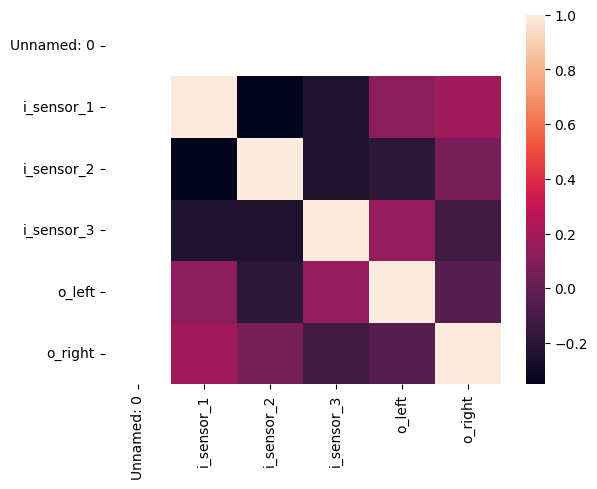

In [4]:
import seaborn as sns
sns.heatmap(df.corr())

# Scale/convert input values

In [5]:
df = df.astype({'o_left': int, 'o_right': int})   

In [6]:
df.head()

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right
0,0,-1,189,79,0,0
1,0,-1,186,79,0,0
2,0,-1,182,79,0,0
3,0,-1,178,79,0,0
4,0,-1,174,79,0,0


In [7]:
df[df['o_left']==1]

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right
745,0,-1,119,171,1,0
772,0,-1,85,195,1,0
782,0,197,80,201,1,0
797,0,173,-1,201,1,0
807,0,157,-1,201,1,0
...,...,...,...,...,...,...
2299,0,-1,109,81,1,0
2301,0,-1,99,77,1,0
2304,0,-1,92,79,1,0
2311,0,-1,90,81,1,0


# Set Train and test 

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop(['o_left','o_right','Unnamed: 0'],axis=1).values
y = df[['o_left','o_right']].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=101)

# Create neural network

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = Sequential()
X_train.shape

2022-08-24 18:35:49.959310: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-24 18:35:49.959332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: G15-5510
2022-08-24 18:35:49.959337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: G15-5510
2022-08-24 18:35:49.959399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-08-24 18:35:49.959414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-08-24 18:35:49.959418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.85.2
2022-08-24 18:35:49.959903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in 

(2240, 3)

In [11]:
model.add(Dense(units=8, input_dim=3,activation='relu'))

model.add(Dense(units=8,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam')

# Train model

In [12]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=150,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/150
70/70 [==============================] - 0s 2ms/step - loss: 2.3312 - val_loss: 1.6419
Epoch 2/150
70/70 [==============================] - 0s 903us/step - loss: 1.1328 - val_loss: 0.8493
Epoch 3/150
70/70 [==============================] - 0s 904us/step - loss: 0.5481 - val_loss: 0.3304
Epoch 4/150
70/70 [==============================] - 0s 866us/step - loss: 0.3440 - val_loss: 0.2686
Epoch 5/150
70/70 [==============================] - 0s 877us/step - loss: 0.3000 - val_loss: 0.2683
Epoch 6/150
70/70 [==============================] - 0s 864us/step - loss: 0.2759 - val_loss: 0.2263
Epoch 7/150
70/70 [==============================] - 0s 912us/step - loss: 0.2476 - val_loss: 0.2164
Epoch 8/150
70/70 [==============================] - 0s 866us/step - loss: 0.2286 - val_loss: 0.2054
Epoch 9/150
70/70 [==============================] - 0s 895us/step - loss: 0.2043 - val_loss: 0.1993
Epoch 10/150
70/70 [==============================] - 0s 891us/step - loss: 0.1990 - val_loss

70/70 [==============================] - 0s 890us/step - loss: 0.1792 - val_loss: 0.1909
Epoch 82/150
70/70 [==============================] - 0s 894us/step - loss: 0.1744 - val_loss: 0.1841
Epoch 83/150
70/70 [==============================] - 0s 877us/step - loss: 0.1766 - val_loss: 0.1799
Epoch 84/150
70/70 [==============================] - 0s 921us/step - loss: 0.1724 - val_loss: 0.1794
Epoch 85/150
70/70 [==============================] - 0s 947us/step - loss: 0.1715 - val_loss: 0.1778
Epoch 86/150
70/70 [==============================] - 0s 866us/step - loss: 0.1749 - val_loss: 0.1740
Epoch 87/150
70/70 [==============================] - 0s 876us/step - loss: 0.1722 - val_loss: 0.1799
Epoch 88/150
70/70 [==============================] - 0s 879us/step - loss: 0.1685 - val_loss: 0.1994
Epoch 89/150
70/70 [==============================] - 0s 879us/step - loss: 0.1792 - val_loss: 0.2042
Epoch 90/150
70/70 [==============================] - 0s 877us/step - loss: 0.1774 - val_loss: 

In [13]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

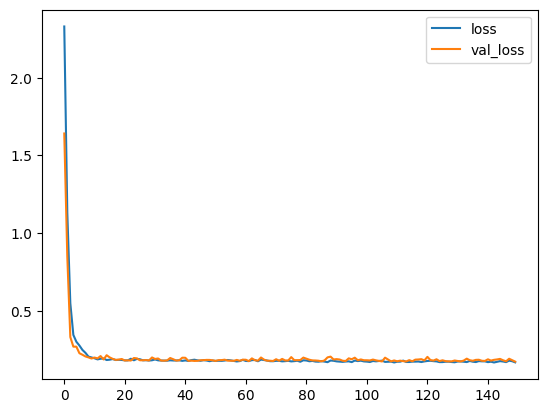

In [14]:
model_loss.plot()

In [ ]:
from car_game.car_game import CarGame
from car_game.road_enum import RoadEnum

car_game = CarGame(screen_size=(1600, 1200), car_speed=2, frame_rate=60,
                   road=RoadEnum.ONE, sensor_threshold=400, generate_train_data=False, nn_model=model)

car_game.start_game()


pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
1/1 [==============================] - 0s 47ms/step
[[0.85717344 0.14282654]]
left
1/1 [==============================] - 0s 10ms/step
[[0.14272635 0.85727364]]
right
1/1 [==============================] - 0s 10ms/step
[[0.92579395 0.07420604]]
left
1/1 [==============================] - 0s 11ms/step
[[0.14272635 0.85727364]]
right
1/1 [==============================] - 0s 11ms/step
[[0.8879781  0.11202198]]
left
1/1 [==============================] - 0s 10ms/step
[[0.14272635 0.85727364]]
right
1/1 [==============================] - 0s 10ms/step
[[0.8139856 0.1860144]]
left
1/1 [==============================] - 0s 10ms/step
[[0.13455306 0.865447  ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.7354681  0.26453188]]
left
1/1 [==============================] - 0s 10ms/step
[[0.11650554 0.88349444]]
right
1/1 [==============================] - 0s 10ms/step
[[

1/1 [==============================] - 0s 10ms/step
[[0.16408008 0.83591986]]
right
1/1 [==============================] - 0s 10ms/step
[[0.94294167 0.05705836]]
left
1/1 [==============================] - 0s 10ms/step
[[0.12373869 0.8762613 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.8879781  0.11202198]]
left
1/1 [==============================] - 0s 10ms/step
[[0.16408008 0.83591986]]
right
1/1 [==============================] - 0s 13ms/step
[[0.83433664 0.16566344]]
left
1/1 [==============================] - 0s 10ms/step
[[0.14272635 0.85727364]]
right
1/1 [==============================] - 0s 10ms/step
[[0.7354681  0.26453188]]
left
1/1 [==============================] - 0s 10ms/step
[[0.14272635 0.85727364]]
right
1/1 [==============================] - 0s 10ms/step
[[0.62452084 0.37547907]]
left
1/1 [==============================] - 0s 10ms/step
[[0.14272635 0.85727364]]
right
1/1 [==============================] - 0s 10ms/step
[[0.49028343 0.50971663]]
rig

1/1 [==============================] - 0s 10ms/step
[[0.3452002  0.65479976]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9562156 0.0437844]]
left
1/1 [==============================] - 0s 10ms/step
[[0.3089849  0.69101506]]
right
1/1 [==============================] - 0s 10ms/step
[[0.91930044 0.08069963]]
left
1/1 [==============================] - 0s 10ms/step
[[0.3089849  0.69101506]]
right
1/1 [==============================] - 0s 10ms/step
[[0.8786092  0.12139083]]
left
1/1 [==============================] - 0s 10ms/step
[[0.3089849  0.69101506]]
right
1/1 [==============================] - 0s 10ms/step
[[0.82138246 0.17861754]]
left
1/1 [==============================] - 0s 10ms/step
[[0.29456174 0.70543826]]
right
1/1 [==============================] - 0s 10ms/step
[[0.745011   0.25498903]]
left
1/1 [==============================] - 0s 10ms/step
[[0.29456174 0.70543826]]
right
1/1 [==============================] - 0s 10ms/step
[[0.63142574 0.36857423]]
left


1/1 [==============================] - 0s 10ms/step
[[9.933942e-04 9.990067e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.01102121 0.9889788 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.11019014 0.8898099 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.35218078 0.64781916]]
right
1/1 [==============================] - 0s 10ms/step
[[0.2510973  0.74890274]]
right
1/1 [==============================] - 0s 10ms/step
[[0.00821351 0.9917864 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.00672164 0.9932783 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.01376168 0.98623836]]
right
1/1 [==============================] - 0s 10ms/step
[[0.01286874 0.9871313 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.00217769 0.9978223 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.8250957  0.17490429]]
left
1/1 [==============================] - 0s 10ms/step
[[4.1138369e-04 9.995

1/1 [==============================] - 0s 10ms/step
[[0.88805354 0.11194649]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00117995 0.99882   ]]
right
1/1 [==============================] - 0s 10ms/step
[[5.6083663e-04 9.9943918e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.88208854 0.11791149]]
left
1/1 [==============================] - 0s 10ms/step
[[0.88805354 0.11194649]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00211237 0.9978877 ]]
right
1/1 [==============================] - 0s 10ms/step
[[5.6083663e-04 9.9943918e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.78006005 0.21993993]]
left
1/1 [==============================] - 0s 10ms/step
[[0.8875945  0.11240541]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00211237 0.9978877 ]]
right
1/1 [==============================] - 0s 10ms/step
[[5.9587683e-04 9.9940407e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.8345468

1/1 [==============================] - 0s 10ms/step
[[0.8850608  0.11493926]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00119819 0.9988018 ]]
right
1/1 [==============================] - 0s 10ms/step
[[5.432014e-04 9.994568e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.87770015 0.12229981]]
left
1/1 [==============================] - 0s 10ms/step
[[0.8850608  0.11493926]]
left
1/1 [==============================] - 0s 11ms/step
[[0.00211237 0.9978877 ]]
right
1/1 [==============================] - 0s 10ms/step
[[5.432014e-04 9.994568e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.79059637 0.2094036 ]]
left
1/1 [==============================] - 0s 10ms/step
[[0.8850608  0.11493926]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00211237 0.9978877 ]]
right
1/1 [==============================] - 0s 10ms/step
[[5.771380e-04 9.994229e-01]]
right
1/1 [==============================] - 0s 11ms/step
[[0.83390903 0.16

1/1 [==============================] - 0s 10ms/step
[[5.3560082e-04 9.9946445e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.87214637 0.12785363]]
left
1/1 [==============================] - 0s 11ms/step
[[0.88805354 0.11194649]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00112689 0.99887305]]
right
1/1 [==============================] - 0s 10ms/step
[[5.3560082e-04 9.9946445e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.87214637 0.12785363]]
left
1/1 [==============================] - 0s 10ms/step
[[0.88805354 0.11194649]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00198678 0.99801314]]
right
1/1 [==============================] - 0s 10ms/step
[[5.3560082e-04 9.9946445e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.80486023 0.19513977]]
left
1/1 [==============================] - 0s 10ms/step
[[0.7885709  0.21142915]]
left
1/1 [==============================] - 0s 10ms/step
[[0.00333926

1/1 [==============================] - 0s 11ms/step
[[0.8716319  0.12836815]]
left
1/1 [==============================] - 0s 10ms/step
[[5.176358e-04 9.994824e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.87093705 0.12906289]]
left
1/1 [==============================] - 0s 11ms/step
[[5.1875750e-04 9.9948126e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.87093705 0.12906289]]
left
1/1 [==============================] - 0s 10ms/step
[[5.1875750e-04 9.9948126e-01]]
right
1/1 [==============================] - 0s 11ms/step
[[0.87093705 0.12906289]]
left
1/1 [==============================] - 0s 10ms/step
[[5.1875750e-04 9.9948126e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.8680821  0.13191795]]
left
1/1 [==============================] - 0s 10ms/step
[[5.1875750e-04 9.9948126e-01]]
right
1/1 [==============================] - 0s 11ms/step
[[0.8001424  0.19985761]]
left
1/1 [==============================] - 0s 10ms/step
[[

1/1 [==============================] - 0s 10ms/step
[[0.9448021  0.05519792]]
left
1/1 [==============================] - 0s 10ms/step
[[0.09774563 0.90225434]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9448021  0.05519792]]
left
1/1 [==============================] - 0s 11ms/step
[[0.09774563 0.90225434]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9448021  0.05519792]]
left
1/1 [==============================] - 0s 10ms/step
[[0.08459347 0.9154065 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9448021  0.05519792]]
left
1/1 [==============================] - 0s 10ms/step
[[0.08702091 0.91297907]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9448021  0.05519792]]
left
1/1 [==============================] - 0s 10ms/step
[[0.08011666 0.9198833 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9448021  0.05519792]]
left
1/1 [==============================] - 0s 10ms/step
[[0.08207864 0.91792136]]
righ

In [109]:
import numpy as np
import pygame

while car_game.game_over:
    input_model = np.array([[car_game.distance_sensor_1,car_game.distance_sensor_2,car_game.distance_sensor_3]])
    prediction = model.predict(input_model)
    
    print(prediction)
    
    if prediction[0][0] >= 0.5:
        newevent = pygame.event.Event(pygame.locals.KEYDOWN, key=pygame.K_LEFT)
        print('left')
    elif prediction[0][1] >= 0.5:
        newevent = pygame.event.Event(pygame.locals.KEYDOWN, key=pygame.K_RIGHT)
        print('right')
        
    pygame.event.post(newevent)
        
    
    
    
    

AttributeError: 'CarGame' object has no attribute 'game_over'

In [ ]:
newevent = pygame.event.Event(pygame.locals.KEYDOWN, key=pygame.K_RIGHT)
pygame.event.post(newevent)

In [ ]:
prediction = model.predict(input_model)

In [ ]:
prediction[0][1]

24/24 [==============================] - 0s 562us/step


array([0.37415695, 0.625843  , 0.37415695, ..., 0.625843  , 0.37415695,
       0.625843  ], dtype=float32)